In [102]:
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jieba

In [3]:
# 加载数据集
train_df = pd.read_csv("../data/train.csv", header=None, index_col=None, sep="\t", names=["label", "text"])
dev_df = pd.read_csv("../data/dev.csv", header=None, index_col=None, sep="\t", names=["label", "text"])
print(train_df.shape)
print(dev_df.shape)
train_df.head(3)

(53360, 2)
(10000, 2)


,label,text
0,news_edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？
1,news_finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告
2,news_house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？


In [17]:
# 把 label 中的统一前缀去掉吧
train_df["label"] = train_df["label"].apply(lambda x: x.split("_")[-1])
dev_df["label"] = dev_df["label"].apply(lambda x: x.split("_")[-1])
train_df.head(3)

,label,text
0,edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？
1,finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告
2,house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？


In [18]:
# 加载标签
with open("../data/label.json", "r", encoding="utf-8") as f:
    label_dict = json.load(f)

# 同样, 去掉前缀
label2id = dict((k.split("_")[-1], v["label_id"]) for k, v in label_dict.items())
label2id

{'story': 0,
 'culture': 1,
 'entertainment': 2,
 'sports': 3,
 'finance': 4,
 'house': 5,
 'car': 6,
 'edu': 7,
 'tech': 8,
 'military': 9,
 'travel': 10,
 'world': 11,
 'stock': 12,
 'agriculture': 13,
 'game': 14}

In [19]:
# 统计训练集中标签的分布
train_df["label"].value_counts()

tech             5955
finance          5200
entertainment    4976
world            4851
car              4118
culture          4081
sports           3991
military         3632
edu              3437
game             3390
travel           3368
agriculture      2886
house            2107
story            1111
stock             257
Name: label, dtype: int64

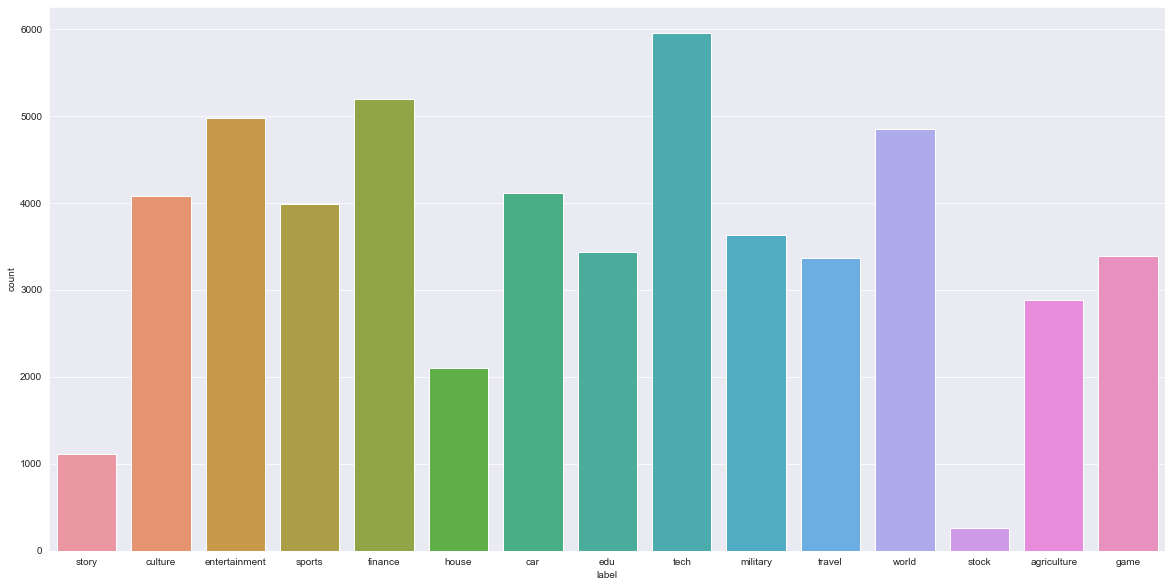

In [21]:
# 可视化
sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))
sns.countplot(x="label", data=train_df, order=label2id.keys())
plt.show()

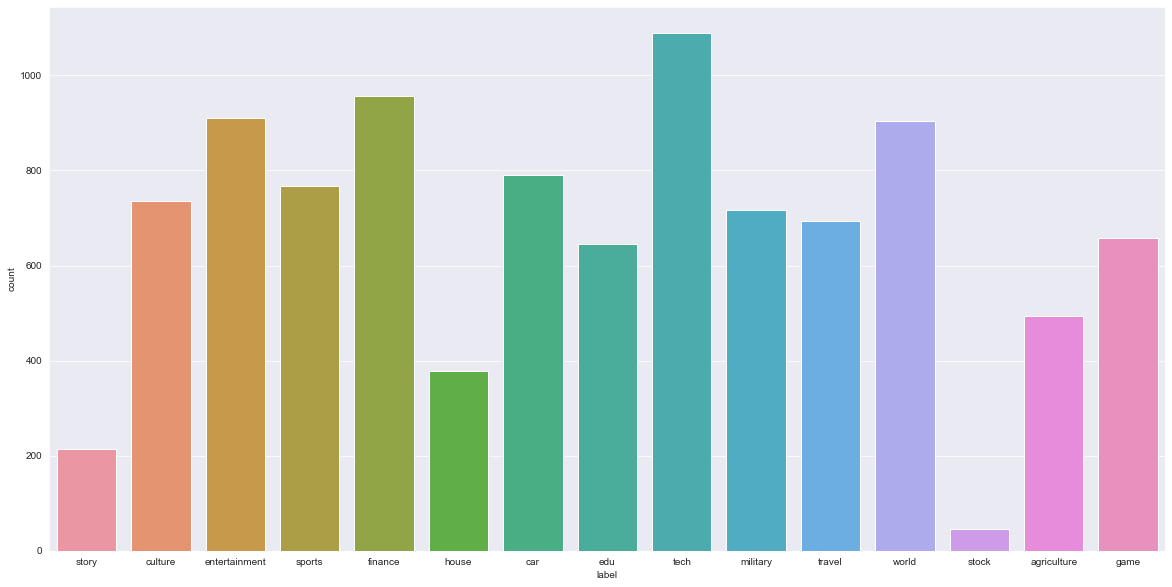

In [24]:
# 在 dev 上也看下
sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))
sns.countplot(x="label", data=dev_df, order=label2id.keys())
plt.show()

In [36]:
# 聚合 train_df 和 dev_df
train_df["type"] = "train"
dev_df["type"] = "dev"
df = pd.concat([train_df, dev_df], axis=0)
df.head(3)

,label,text,type
0,edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？,train
1,finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告,train
2,house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？,train


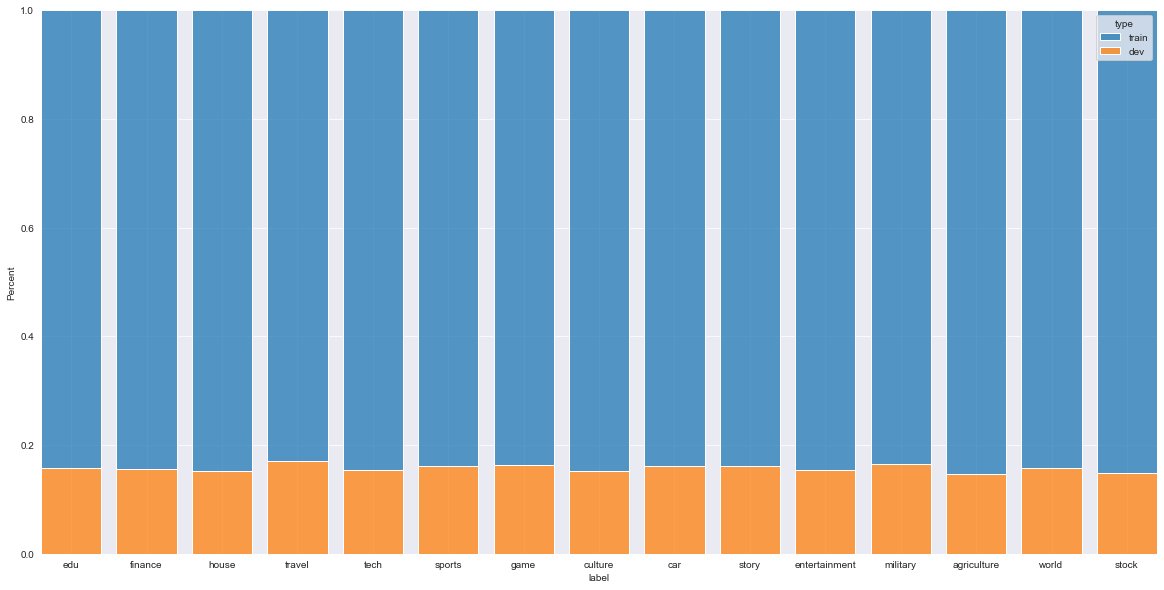

In [47]:
# 对比下训练集和验证集的标签分布
sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))
# 用 fill 能看出来基本是一样的
sns.histplot(x="label", data=df, hue="type", stat="percent", multiple="fill", shrink=.8)
plt.show()

In [48]:
# 计算长度
train_df["length"] = train_df["text"].apply(lambda x: len(x))
dev_df["length"] = dev_df["text"].apply(lambda x: len(x))
df["length"] = df["text"].apply(lambda x: len(x))

In [50]:
print(train_df["length"].describe())
print("=====================================")
print(dev_df["length"].describe())

count    53360.000000
mean        22.130941
std          7.309748
min          2.000000
25%         17.000000
50%         22.000000
75%         28.000000
max        145.000000
Name: length, dtype: float64
count    10000.000000
mean        22.208500
std          7.355477
min          4.000000
25%         17.000000
50%         23.000000
75%         28.000000
max        129.000000
Name: length, dtype: float64


In [51]:
# 看看 99 和 95 分位的长度. 如果用在 bert 上, 可以选 40
print(train_df["length"].quantile(0.99))
print(train_df["length"].quantile(0.95))
print(dev_df["length"].quantile(0.99))
print(dev_df["length"].quantile(0.95))

39.0
32.0
39.0
33.0


In [59]:
# 看下每个分类的长度分布
df.groupby("label")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
agriculture,3380.0,21.240828,7.178442,4.0,15.0,22.0,27.0,49.0
car,4909.0,22.613974,7.225350,3.0,17.0,23.0,29.0,53.0
culture,4817.0,19.257422,7.119892,4.0,14.0,17.0,24.0,51.0
edu,4083.0,21.286064,7.912027,2.0,15.0,21.0,27.0,58.0
entertainment,5886.0,23.715596,6.712622,4.0,19.0,25.0,29.0,58.0
finance,6156.0,21.830247,7.372701,5.0,16.0,22.0,27.0,145.0
game,4049.0,23.927883,6.893332,5.0,19.0,25.0,29.0,50.0
house,2485.0,21.272837,7.035939,4.0,16.0,21.0,26.0,49.0
military,4348.0,22.504830,7.070855,2.0,17.0,23.0,28.0,55.0


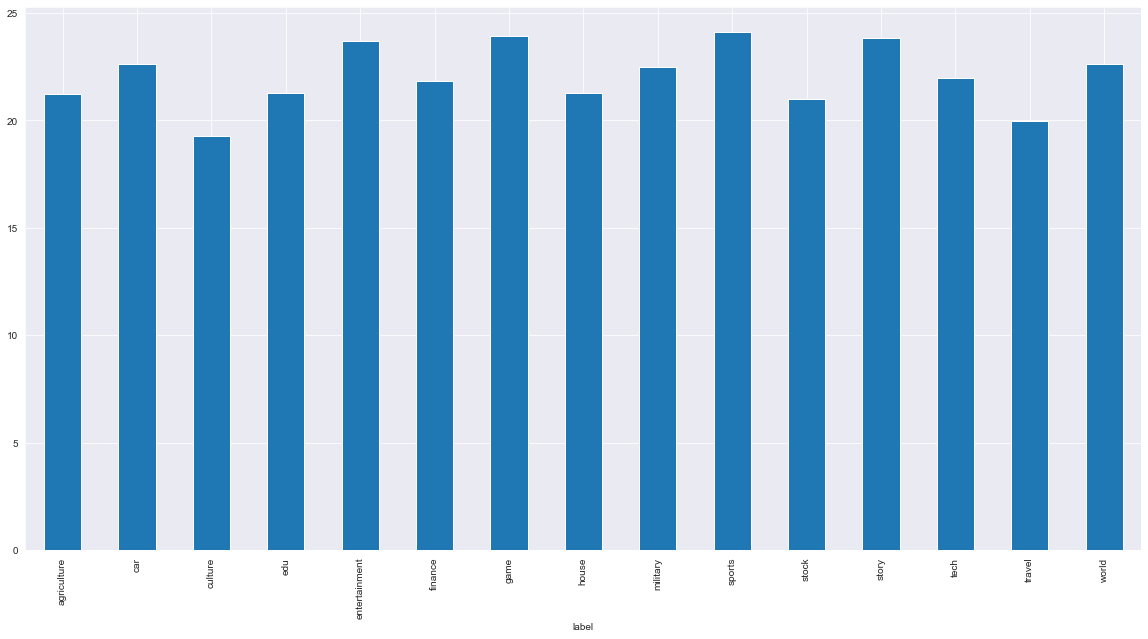

In [72]:
plt.figure(figsize=(20, 10))
df.groupby("label")["length"].describe()["mean"].plot(kind="bar")
plt.show()

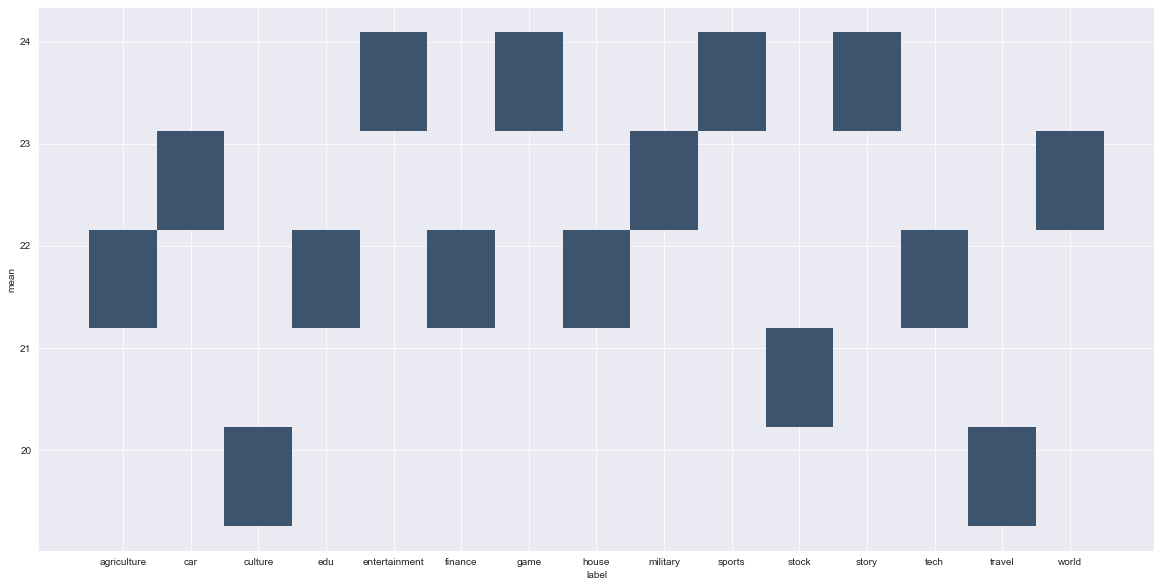

In [91]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))
sns.histplot(df.groupby("label")["length"].describe(), x="label", y="mean", shrink=.8)
plt.show()

In [95]:
# 先看下全局的好了
def count_word(text_list):
    word_dict = defaultdict(int)
    for text in text_list:
        for word in text:
            word_dict[word] = word_dict[word] + 1
    
    # 排序下
    word_list = list(sorted(word_dict.items(), key=lambda x: x[1], reverse=True))
    return word_list

In [99]:
word_list = count_word(df["text"].tolist())
word_list[:20]

[('，', 41311),
 ('？', 28989),
 ('的', 26897),
 ('一', 12432),
 ('么', 12408),
 ('国', 11549),
 ('！', 11373),
 ('是', 10833),
 ('0', 10270),
 ('不', 10077),
 ('人', 10032),
 ('有', 9670),
 ('大', 9483),
 ('：', 9083),
 ('了', 9005),
 (' ', 8732),
 ('中', 7947),
 ('1', 7899),
 ('为', 7664),
 ('什', 7374)]

In [104]:
# 看下 tech 这个类别下的词频
tech_df = df[df["label"] == "tech"]
tech_word_list = count_word(tech_df["text"].tolist())
# 去掉 word_list 前 20 个最通用的
drop_set = set([word for word, _ in word_list[:20]])
tech_word_list = [word for word in tech_word_list if word[0] not in drop_set]
tech_word_list[:20]

[('机', 1253),
 ('能', 886),
 ('手', 882),
 ('在', 844),
 ('业', 843),
 ('用', 753),
 ('如', 746),
 ('2', 743),
 ('5', 719),
 ('个', 702),
 ('你', 698),
 ('“', 676),
 ('”', 673),
 ('何', 654),
 ('新', 650),
 ('吗', 650),
 ('会', 634),
 ('发', 619),
 ('小', 591),
 ('来', 579)]

In [105]:
# 用下结巴分词看看
def count_jieba_word(text_list):
    word_dict = defaultdict(int)
    for text in text_list:
        for word in jieba.lcut(text):
            word_dict[word] = word_dict[word] + 1
    
    # 排序下
    word_list = list(sorted(word_dict.items(), key=lambda x: x[1], reverse=True))
    return word_list

In [109]:
word_list = count_jieba_word(df["text"].tolist())
word_list[:20]

[('，', 41311),
 ('？', 28989),
 ('的', 25852),
 ('！', 11373),
 ('：', 9083),
 (' ', 8732),
 ('了', 8108),
 ('是', 6934),
 ('“', 6613),
 ('”', 6589),
 ('你', 5831),
 ('有', 4864),
 ('在', 4751),
 ('吗', 4611),
 ('什么', 3641),
 ('中国', 3481),
 ('为什么', 3317),
 ('如何', 3191),
 ('和', 2950),
 ('都', 2899)]

In [112]:
# 同样, 用 jieba 分词看下 tech 这个类别下的词频
tech_df = df[df["label"] == "tech"]
tech_word_list = count_jieba_word(tech_df["text"].tolist())
# 去掉 word_list 前 20 个最通用的
drop_set = set([word for word, _ in word_list[:20]])
tech_word_list = [word for word in tech_word_list if word[0] not in drop_set]
# 去掉单个词的
tech_word_list = [word for word in tech_word_list if len(word[0]) > 1]
tech_word_list[:20]

[('手机', 586),
 ('小米', 288),
 ('怎么', 286),
 ('联想', 263),
 ('华为', 224),
 ('微信', 204),
 ('哪些', 191),
 ('企业', 184),
 ('腾讯', 173),
 ('现在', 171),
 ('区块', 168),
 ('未来', 168),
 ('苹果', 167),
 ('公司', 163),
 ('5G', 162),
 ('2018', 161),
 ('如果', 156),
 ('一个', 156),
 ('可以', 154),
 ('科技', 153)]